## Feature (Engineering) Regressions using ML/DL Algorithms

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-09-05 09:54:17.397692: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 09:54:17.422953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 09:54:17.467426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 09:54:17.484676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 09:54:17.507786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [3]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
fovs = ['A2_2']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [5]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [10]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [11]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [12]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [13]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 97681, 99 tracks, 96000 left
tracked cell 97491, 26 tracks, 88600 left
tracked cell 97080, 1 tracks, 70500 left
tracked cell 97030, 1 tracks, 69600 left
tracked cell 96323, 1 tracks, 69200 left
tracked cell 95568, 1 tracks, 68800 left
tracked cell 94699, 1 tracks, 68200 left
tracked cell 94670, 3 tracks, 68100 left
tracked cell 94178, 1 tracks, 67300 left
tracked cell 92330, 2 tracks, 66100 left
tracked cell 92141, 5 tracks, 65900 left
tracked cell 92088, 1 tracks, 65800 left
tracked cell 91522, 1 tracks, 65600 left
tracked cell 90715, 1 tracks, 64800 left
tracked cell 89955, 19 tracks, 63900 left
tracked cell 88654, 1 tracks, 62700 left
tracked cell 88173, 2 tracks, 62600 left
tracked cell 87958, 1 tracks, 62400 left
tracked cell 87425, 36 tracks, 61900 left
tracked cell 86624, 1 tracks, 61200 left
tracked cell 86238, 1 tracks, 60900 left
tracked cell 83339, 1 tracks, 58900 left
tracked cell 83179, 1 tracks, 58800 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [14]:
num_latent_dim=256
data_vae = np.load(f'../o2vae/features_vae{num_latent_dim}_LI204601_A2_2.npz')
features_vae = data_vae['embeddings']
labels_vae = data_vae['labels']

In [15]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf_vae = features_vae[indsf, :]

In [16]:
for i in indgood_models:
    cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

In [17]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Single-cell Trajectories Over The Cell Features

In [18]:
#Xf_traj = np.zeros((0, (modelSet[0].Xf.shape[1]+n_COMfeatures)*trajl))
#Xf_traj = np.zeros((0, (modelSet[0].Xf_new.shape[1]+n_COMfeatures)*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #data = modelSet[i].Xf_new[modelSet[i].traj, :]
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_new.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0


In [19]:
def get_cellCycInfoTrajs(file_info):
    with open(file_info, 'r') as fp:
        lines = fp.readlines()

    nuc2cytoRatio = []
    CC_vals = []
    frames = []

    for line1, line2, line3 in zip(lines[::3], lines[1::3], lines[2::3]):
        line1 = np.array(line1.strip()[1:-1].split(', '), dtype=float)
        line2 = np.array(line2.strip()[1:-1].split(', '), dtype=float)
        line3 = np.array(line3.strip()[1:-1].split(', '), dtype=int)

        mask = ~np.isnan(line1)
        line1 = line1[mask]
        line2 = line2[mask]
        line3 = line3[mask]

        nuc2cytoRatio.append(line1)
        CC_vals.append(line2)
        frames.append(line3)

    return nuc2cytoRatio, CC_vals, frames

In [20]:
file_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/cellCycInfoRawReporterImgs/'
sname_reporter = "LI204601_G"

## Get Nuc/Cyto Ratios and CC values along all single-cell trajectories  

In [21]:
cc_filename = f"{file_path}{sname_reporter}_{fovs[0]}.dat"
n2c_ratio, cc_vals, frame_numbers = get_cellCycInfoTrajs(cc_filename)

In [22]:
valid_indstm = []
nuc2Cyto_ratio_last_frames = []
model_indc = 0
indstm = np.where(indtreatment_traj == model_indc)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 

for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    # Look for a snippet frame within its full trajectory
    possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])[0]
    if len(possible_indices) > 0:
        nbc_ratio = n2c_ratio[ind_fulltraj][possible_indices[0]]
        nuc2Cyto_ratio_last_frames.append(nbc_ratio)
        valid_indstm.append(indstm[j]) 

nuc2Cyto_ratio_last_frames = np.array(nuc2Cyto_ratio_last_frames)
X = Xf_traj[valid_indstm]  # Use the valid indices to index into Xf_traj
y = nuc2Cyto_ratio_last_frames

<Figure size 640x480 with 0 Axes>

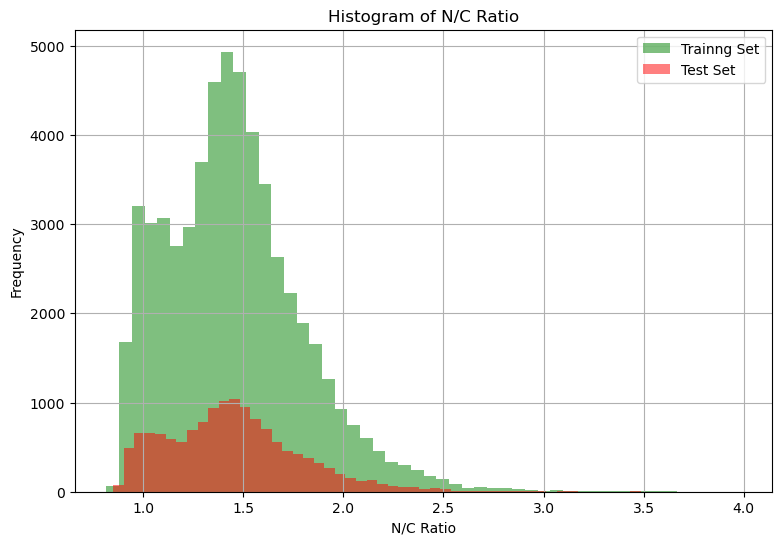

In [23]:
n_bins = 50

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.clf()
plt.figure(figsize = (9, 6))
plt.hist(y_train, bins = n_bins, alpha = 0.5, color = 'g', label = 'Trainng Set')
plt.hist(y_test, bins = n_bins, alpha = 0.5, color='r', label = 'Test Set')
plt.xlabel('N/C Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of N/C Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

37 Non-Zero PCs/Features Selected by LassoCV: [  2   4  12  13  25  26  28  37  55  63  67  70  72  73  80  81  86 106
 108 111 113 116 126 129 136 146 157 179 196 197 206 207 219 237 243 244
 247]


<Figure size 640x480 with 0 Axes>

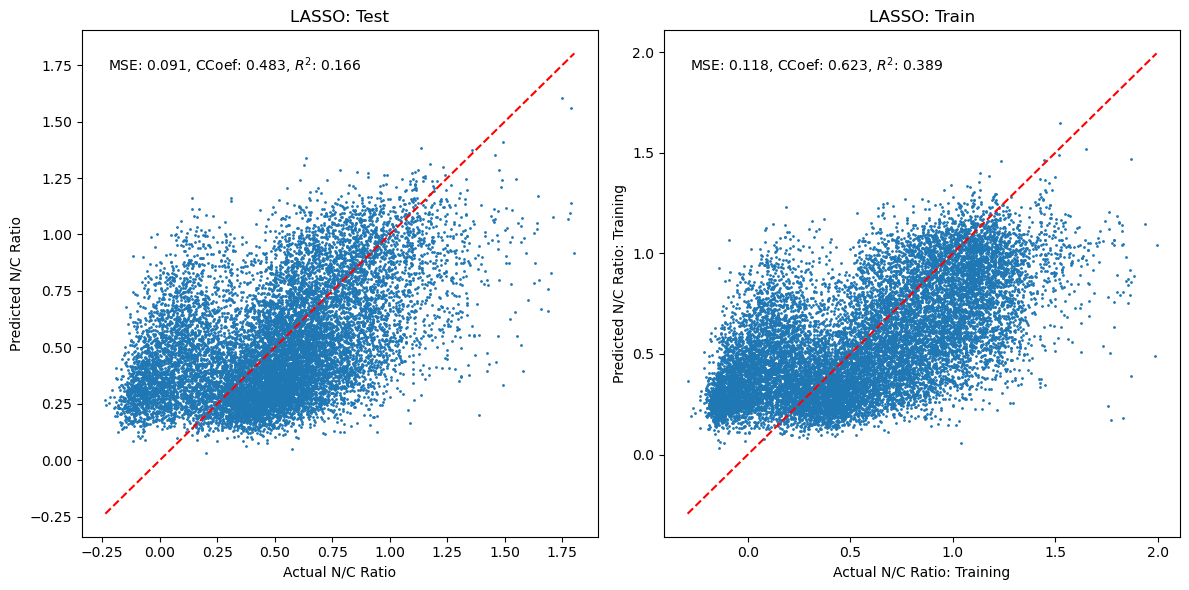

In [27]:
# scaler = StandardScaler() # Scale features with Zero Mean & Unit Variance
scaler = MinMaxScaler() # Scale features in the range [0, 1]
y_log2 = np.log2(y)

#init_alphas = np.array([0.35, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 0.75e-3]) # JC features params
init_alphas = np.array([0.35, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 1e-3, 0.5e-4]) # VAE features params 
X_train, X_test, y_train, y_test = train_test_split(X, y_log2,
                                                    test_size=0.2,
                                                    random_state=42)

############## Training & Testing using LASSOCV directly on original features ##############
target_density = 500; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axs = axs.flatten()

############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
X_train_trim = scaler.fit_transform(X_train_trim)
    
# Least Absolute Shrinkage and Selection Operator (LASSO)/ElasticCV
pipe = Pipeline([
                ('scaler', MinMaxScaler()), 
                ('linReg', LassoCV(cv=5, 
                #('linReg', ElasticNetCV(cv=5, l1_ratio = [.1, .2, .3, .4, .5, .6, .7, .8, .9],
                                    alphas=init_alphas, 
                                    max_iter=1000000, tol=1e-4, selection='random', n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)

alphas = pipe.named_steps['linReg'].alphas_ # Get the alphas from the LassoCV object
best_alpha = pipe.named_steps['linReg'].alpha_ # Get the best alpha from the LassoCV object
#print(f"Best alpha: {best_alpha}, alphas: {alphas}")

X_test = scaler.transform(X_test)
y_pred_lasso = pipe.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_lasso) # Mean-Squared Error
r2_test = r2_score(y_test, y_pred_lasso) # R^2
correlation_matrix = np.corrcoef(y_test, y_pred_lasso)

################### Which features are considered "important" by LASSOCV/ElasticCV ###################
coefficients = pipe.named_steps['linReg'].coef_
# Identify non-zero coefficients (features to keep)
non_zero_indices = np.where(coefficients != 0)[0]
print(f"{non_zero_indices.size} Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
corr_coeff = correlation_matrix[0, 1]
axs[0].scatter(y_test, y_pred_lasso, s = 1)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Best fit line 
axs[0].set_xlabel('Actual N/C Ratio')
axs[0].set_ylabel('Predicted N/C Ratio')
axs[0].set_title(f'LASSO: Test')
axs[0].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}, $R^2$: {r2_test:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

y_pred_lasso_train = pipe.predict(X_train_trim)
mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
r2_train = r2_score(y_train_trim, y_pred_lasso_train) # R^2
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
corr_coeff = correlation_matrix[0, 1]
axs[1].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[1].plot([y_train_trim.min(), y_train_trim.max()], [y_train_trim.min(), y_train_trim.max()], 'r--') # Best fit line 
axs[1].set_xlabel('Actual N/C Ratio: Training')
axs[1].set_ylabel('Predicted N/C Ratio: Training')
axs[1].set_title(f'LASSO: Train')
axs[1].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}, $R^2$: {r2_train:.3f}',
            transform=axs[1].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')
plt.tight_layout()
plt.savefig(f'lassoTrainTrimData_A2_2_trajl{trajl}_vae{num_latent_dim}_log2.png', dpi = 400, bbox_inches='tight')
#plt.show()

In [26]:
def unique_predictive_features(n_top_cont_features = 5):
    loadings = pca.components_
    feature_inds = np.array([]).astype(int)
    for i, pc in enumerate(loadings):
        # Gets indices of the top features for each PC
        top_features_indices = np.argsort(np.abs(pc))[-n_top_cont_features:] 
        #print(f"Top {n_cf} contributing feature indices for PC{i+1}: {top_features_indices}")
        feature_inds = np.append(feature_inds, top_features_indices)
    unique_feature_inds = np.unique(feature_inds)

    return unique_feature_inds